In [2]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

INPUT_SIZE = 28 * 28 
NUM_CLASSES = 10
BATCH_SIZE = 500 
EPOCHS = 5         
SEED = 42          

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = datasets.MNIST(root='../data', train=True, transform=transform, download=False)
test_dataset = datasets.MNIST(root='../data', train=False, transform=transform, download=False)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

## Tweaking Learning Rate for OLNM

--- Starting Training for OLNM with Learning Rate: 3.0 ---
LR: 3.0, Epoch [1/5], Final Batch Loss: 0.03810
LR: 3.0, Epoch [2/5], Final Batch Loss: 0.03749
LR: 3.0, Epoch [3/5], Final Batch Loss: 0.03471
LR: 3.0, Epoch [4/5], Final Batch Loss: 0.03483
LR: 3.0, Epoch [5/5], Final Batch Loss: 0.03242
Final Accuracy for LR 3.0: 74.81%

--- Starting Training for OLNM with Learning Rate: 2.0 ---
LR: 2.0, Epoch [1/5], Final Batch Loss: 0.02660
LR: 2.0, Epoch [2/5], Final Batch Loss: 0.02559
LR: 2.0, Epoch [3/5], Final Batch Loss: 0.02266
LR: 2.0, Epoch [4/5], Final Batch Loss: 0.02376
LR: 2.0, Epoch [5/5], Final Batch Loss: 0.01951
Final Accuracy for LR 2.0: 83.87%

--- Starting Training for OLNM with Learning Rate: 1.0 ---
LR: 1.0, Epoch [1/5], Final Batch Loss: 0.01474
LR: 1.0, Epoch [2/5], Final Batch Loss: 0.01141
LR: 1.0, Epoch [3/5], Final Batch Loss: 0.01048
LR: 1.0, Epoch [4/5], Final Batch Loss: 0.01041
LR: 1.0, Epoch [5/5], Final Batch Loss: 0.00836
Final Accuracy for LR 1.0: 92.73%

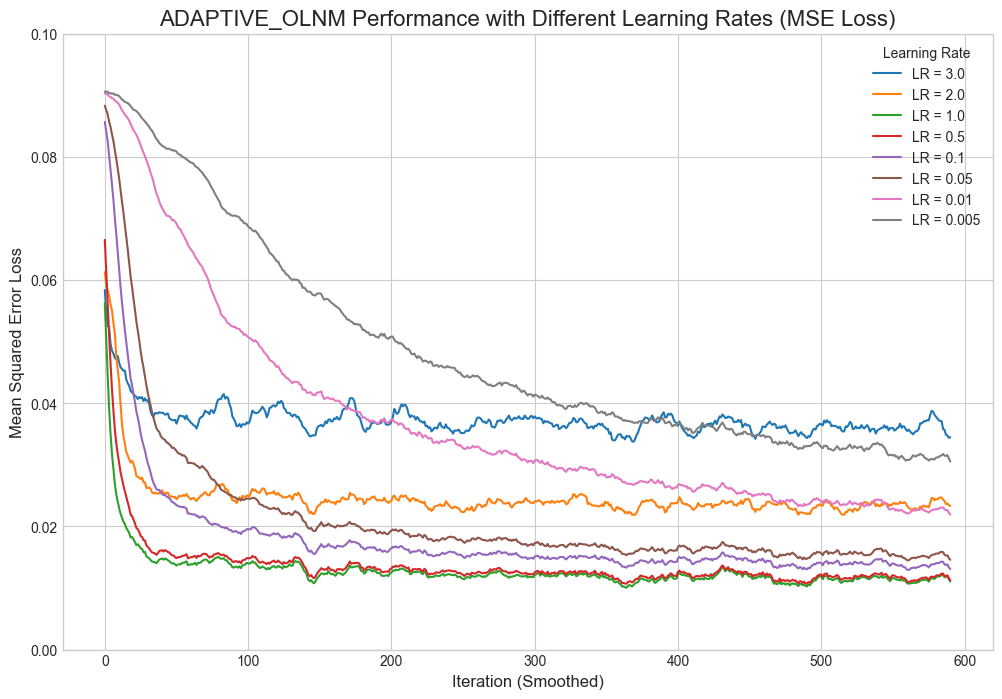

In [ ]:
import sys, os
sys.path.append(os.path.abspath('..'))

LEARNING_RATES = [2.0, 1.0, 0.5, 0.1, 0.05, 0.01, 0.005]
criterion = nn.MSELoss()
all_loss_histories = {}

for lr in LEARNING_RATES:
    print(f"--- Starting Training for OLNM with Learning Rate: {lr} ---")
    torch.manual_seed(SEED)
    from olnm import OLNM as ORIGINAL_OLNM
    model = LogisticRegression(INPUT_SIZE, NUM_CLASSES)
    optimizer = ORIGINAL_OLNM(model.parameters(), lr=lr, c=1000, batch_size=BATCH_SIZE)

    loss_history = []
    
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            def closure(grad=True):
                logits = model(data)
                output_probs = torch.softmax(logits, dim=1)
                target_one_hot = nn.functional.one_hot(target, num_classes=NUM_CLASSES).float()
                loss = criterion(output_probs, target_one_hot)
                if grad:
                    optimizer.zero_grad()
                    loss.backward()
                return loss

            loss = optimizer.step(closure)

            loss_history.append(loss.item())
        
        print(f"LR: {lr}, Epoch [{epoch+1}/{EPOCHS}], Final Batch Loss: {loss.item():.5f}")

    all_loss_histories[lr] = loss_history

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    print(f"Final Accuracy for LR {lr}: {100 * correct / total:.2f}%\n")

# --- Plotting ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))

for lr, history in all_loss_histories.items():
    window_size = 10
    if len(history) > window_size:
        smoothed_history = np.convolve(history, np.ones(window_size)/window_size, mode='valid')
        plt.plot(smoothed_history, label=f'LR = {lr}')
    else:
        plt.plot(history, label=f'LR = {lr}')

plt.title('OLNM Performance with Different Learning Rates (MSE Loss)', fontsize=16)
plt.xlabel('Iteration (Smoothed)', fontsize=12)
plt.ylabel('Mean Squared Error Loss', fontsize=12)
plt.legend(title='Learning Rate', fontsize=10)
plt.ylim(0, 0.1)
plt.show()

## Tweaking C for OLNM

In [4]:
import math
import sys, os
sys.path.append(os.path.abspath('..'))

criterion = nn.MSELoss()
all_loss_histories = {}
lr = 1.0
BATCH_SIZE = 500
base_c = 1/(1/math.sqrt(BATCH_SIZE))
base_cs = [50, 60, 80, 90, 100, 150]
Cs = [round(c * base_c, 0) for c in base_cs]

# T = c / math.sqrt(batch_size)  # ROOT_DECAY 
for c in Cs:
    print(f"--- Starting Training for OLNM with C: {c} ---")
    torch.manual_seed(SEED)
    from olnm import OLNM as ORIGINAL_OLNM
    model = LogisticRegression(INPUT_SIZE, NUM_CLASSES)
    optimizer = ORIGINAL_OLNM(model.parameters(), lr=lr, c=c, batch_size=BATCH_SIZE)

    loss_history = []
    
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            def closure(grad=True):
                logits = model(data)
                output_probs = torch.softmax(logits, dim=1)
                target_one_hot = nn.functional.one_hot(target, num_classes=NUM_CLASSES).float()
                loss = criterion(output_probs, target_one_hot)
                if grad:
                    optimizer.zero_grad()
                    loss.backward()
                return loss

            loss = optimizer.step(closure)

            loss_history.append(loss.item())
        
        print(f"C: {c}, Epoch [{epoch+1}/{EPOCHS}], Final Batch Loss: {loss.item():.5f}")

    all_loss_histories[c] = loss_history

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    print(f"Final Accuracy for C {c}: {100 * correct / total:.2f}%\n")

--- Starting Training for OLNM with C: 1118.0 ---
C: 1118.0, Epoch [1/5], Final Batch Loss: 0.01442
C: 1118.0, Epoch [2/5], Final Batch Loss: 0.01150
C: 1118.0, Epoch [3/5], Final Batch Loss: 0.01034
C: 1118.0, Epoch [4/5], Final Batch Loss: 0.01045
C: 1118.0, Epoch [5/5], Final Batch Loss: 0.00914
Final Accuracy for C 1118.0: 92.52%

--- Starting Training for OLNM with C: 1342.0 ---
C: 1342.0, Epoch [1/5], Final Batch Loss: 0.01428
C: 1342.0, Epoch [2/5], Final Batch Loss: 0.01101
C: 1342.0, Epoch [3/5], Final Batch Loss: 0.01052
C: 1342.0, Epoch [4/5], Final Batch Loss: 0.01072
C: 1342.0, Epoch [5/5], Final Batch Loss: 0.00872
Final Accuracy for C 1342.0: 92.52%

--- Starting Training for OLNM with C: 1789.0 ---
C: 1789.0, Epoch [1/5], Final Batch Loss: 0.01374
C: 1789.0, Epoch [2/5], Final Batch Loss: 0.01120
C: 1789.0, Epoch [3/5], Final Batch Loss: 0.00986
C: 1789.0, Epoch [4/5], Final Batch Loss: 0.01124
C: 1789.0, Epoch [5/5], Final Batch Loss: 0.00837
Final Accuracy for C 1789.

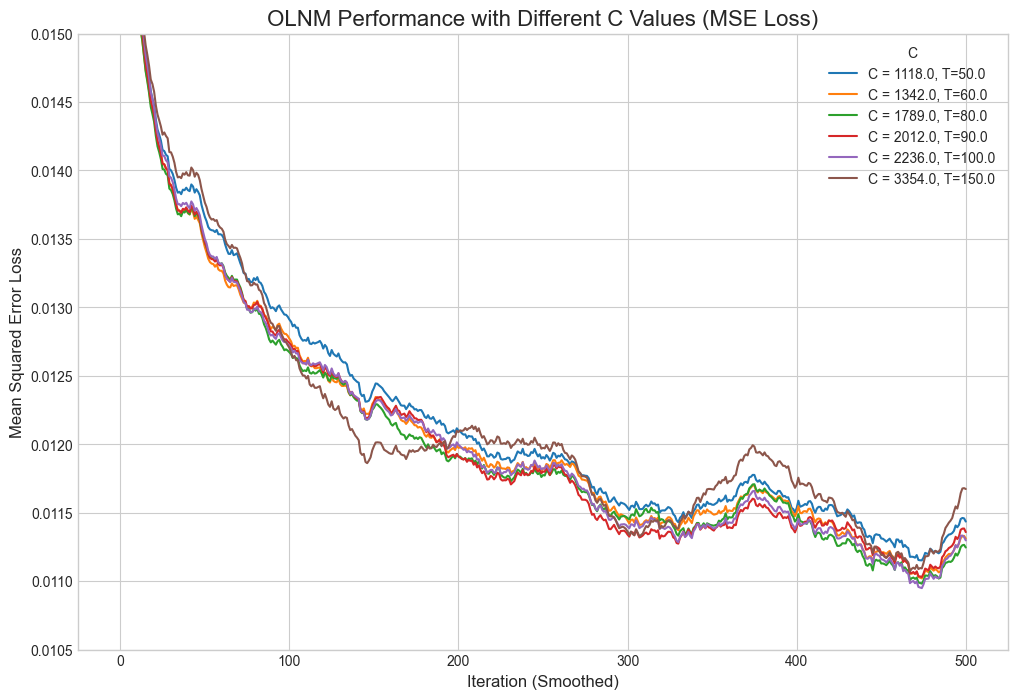

In [8]:
# --- Plotting ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))

for c, history in all_loss_histories.items():
    window_size = 100
    if len(history) > window_size:
        smoothed_history = np.convolve(history, np.ones(window_size)/window_size, mode='valid')
        plt.plot(smoothed_history, label=f'C = {c}, T={round(c / math.sqrt(BATCH_SIZE), 0)}')
    else:
        plt.plot(history, label=f'C = {c}, T={round(c / math.sqrt(BATCH_SIZE), 0)}')

plt.title('OLNM Performance with Different C Values (MSE Loss)', fontsize=16)
plt.xlabel('Iteration (Smoothed)', fontsize=12)
plt.ylabel('Mean Squared Error Loss', fontsize=12)
plt.legend(title='C', fontsize=10)
plt.ylim(0.0105, 0.015)
plt.show()